In [1]:
import glob
import os
from astropy.io import fits
import numpy as np

pathlist = glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.1/s*')
geometry = [os.path.basename(path).split('/')[-1][:7] for path in pathlist]
seddir = '/orange/adamginsburg/w51/TaehwaYoo/SEDmodel/'

b3fluxarr = np.array([]) ; b6fluxarr = np.array([])
b7fluxarr = np.array([])
logmassarr = np.array([]) ; logtemparr = np.array([]) ; loglumarr = np.array([])
logradarr = np.array([])
for path in geometry: # loop over YSO geometry models
    filepath = seddir+path+'/flux_prop.fits'
   
    if not os.path.isfile(filepath):
        continue
    fluxfile = fits.open(filepath)
    
    
    cols = fluxfile[1].columns
    if not 'mass_los' in cols.names:
        continue
    print(path)
    parfilepath = '/blue/adamginsburg/richardson.t/research/flux/pars/'+ path +'_augmented.fits'
    parfile = fits.open(parfilepath)
    # correction of fluxes considering distances 1kpc -> 5.41 kpc (w51e)
    # select 4th value of the aperture grid = 428 au
    
    b6flux = fluxfile[1].data['b6 flux'][:,3]*1e-3*(1/5.41)**2
    b3flux = fluxfile[1].data['b3 flux'][:,3]*1e-3*(1/5.41)**2
    b7flux = fluxfile[1].data['b7 flux'][:,3]*1e-3*(1/5.41)**2

    
    
    masslos = fluxfile[1].data['mass_los'][:,3]
    logmass = np.log10(masslos)
    templos = fluxfile[1].data['temp_los'][:,3]
    logtemp = np.log10(templos)
    luminosity = parfile[1].data['Model Luminosity']
    loglum = np.log10(luminosity)
    radius = parfile[1].data['star.radius']
    lograd = np.log10(radius)
    
    logb3flux = np.log10(b3flux) 
    logb6flux = np.log10(b6flux)
    logb7flux = np.log10(b7flux)
    
    
    logtemparr = np.append(logtemparr, logtemp)
    logmassarr = np.append(logmassarr, logmass)
    loglumarr = np.append(loglumarr, loglum)
    logradarr = np.append(logradarr, lograd)
    
    b3fluxarr = np.append(b3fluxarr,logb3flux)
    b6fluxarr = np.append(b6fluxarr,logb6flux)
    b7fluxarr = np.append(b7fluxarr,logb7flux)
    
b3fluxarr.flatten()
b6fluxarr.flatten()
b7fluxarr.flatten()
logmassarr.flatten()
logtemparr.flatten()
loglumarr.flatten()
logradarr.flatten()


s-pbsmi


/scratch/local/63830109/ipykernel_16426/732712000.py:38: RuntimeWarning: invalid value encountered in log10
  logmass = np.log10(masslos)
/scratch/local/63830109/ipykernel_16426/732712000.py:40: RuntimeWarning: invalid value encountered in log10
  logtemp = np.log10(templos)


s-p-hmi
spu-hmi


/scratch/local/63830109/ipykernel_16426/732712000.py:38: RuntimeWarning: divide by zero encountered in log10
  logmass = np.log10(masslos)


spubsmi
s-pbhmi
s-u-smi
s-ubhmi


/scratch/local/63830109/ipykernel_16426/732712000.py:46: RuntimeWarning: invalid value encountered in log10
  logb3flux = np.log10(b3flux)
/scratch/local/63830109/ipykernel_16426/732712000.py:47: RuntimeWarning: invalid value encountered in log10
  logb6flux = np.log10(b6flux)
/scratch/local/63830109/ipykernel_16426/732712000.py:48: RuntimeWarning: invalid value encountered in log10
  logb7flux = np.log10(b7flux)


spu-smi
s-u-hmi
s-ubsmi
spubhmi
s-p-smi


array([ 0.17231097,  0.17231097,  0.17231097, ..., -0.85917782,
        1.83903787,  1.75027692])

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
index = np.where((np.isfinite(b3fluxarr))&
                 (np.isfinite(b6fluxarr))&
                 (np.isfinite(logradarr)))[0]
X = np.vstack((b3fluxarr[index], b6fluxarr[index]-b3fluxarr[index])).T
y = logradarr[index]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [3]:
model = RandomForestRegressor(n_estimators=500, max_depth=20,oob_score=True, n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.3653445734863193

[ 0.57090952 -0.14629894 -0.65019243 ...  0.09256612 -0.06163781
  0.63831959]
[ 0.58035466 -0.34486157 -0.97428462 ... -0.53253989  0.60508946
  0.28262211]


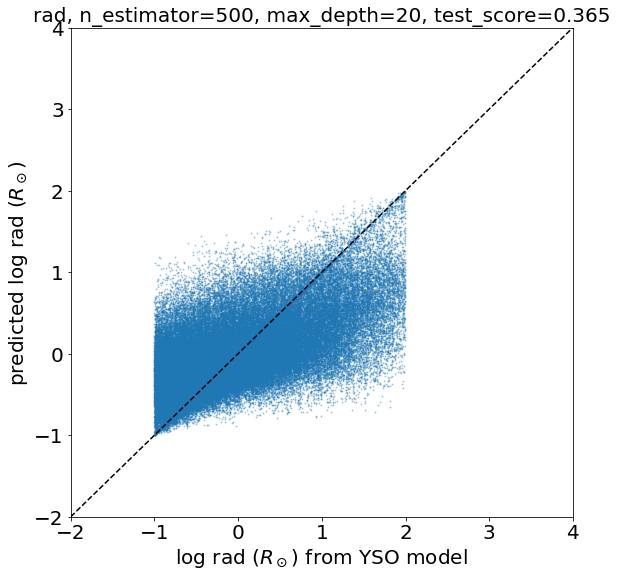

In [5]:
import matplotlib.pyplot as plt
print(model.predict(X_test))
print(y_test)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
plt.rcParams['axes.labelsize']=20

fig = plt.figure(figsize=(9,9))
plt.scatter(y_test, model.predict(X_test),s=1,alpha=0.3)
plt.plot([-2,4],[-2,4], c='k', ls='dashed')
plt.xlim(-2,4)
plt.ylim(-2,4)
plt.xlabel(r'log rad ($R_\odot$) from YSO model')
plt.ylabel(r'predicted log rad ($R_\odot$)')
plt.title('rad, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model.n_estimators,model.max_depth,model.score(X_test, y_test)))
plt.savefig('rad_20_1to1.png')          
          
          

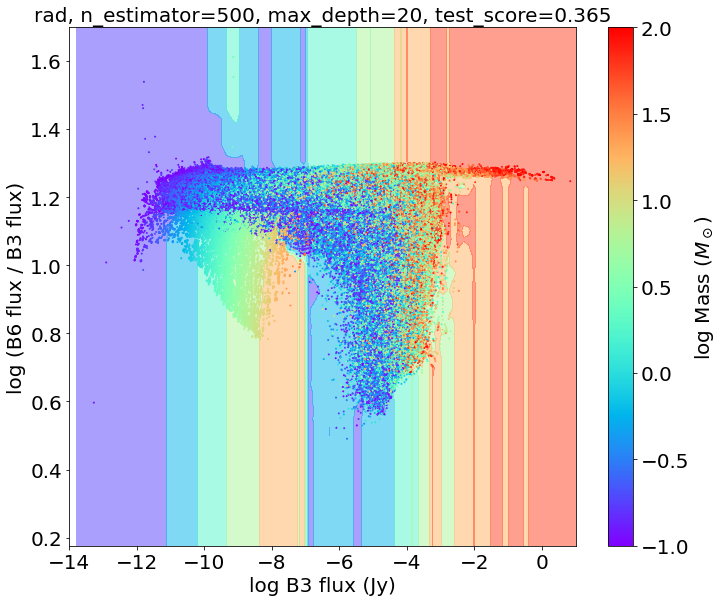

In [8]:
import matplotlib.pyplot as plt

def plot_decision_boundary(ax, model, X, y, alpha=0.5, scatter=True,contour=True, marker=None, vmin=-9,vmax=1.5):
    xx = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
    yy = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)

    XX, YY = np.meshgrid(xx, yy)
    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    cbartick = np.linspace(vmin,vmax,int((vmax-vmin)/0.5)+1)
    if contour:
        ss =ax.contourf(XX, YY, Z, cbartick,alpha=alpha, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
    if scatter:
        if marker == None:
            ss = ax.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
        else:
            ss = ax.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'), marker=marker,vmin=vmin,vmax=vmax)
        
    ax.set_xlabel('log B3 flux (Jy)')
    ax.set_ylabel('log (B6 flux / B3 flux)')
    
    color_bar = plt.colorbar(ss, ax=ax,alpha=1)
    color_bar.set_alpha(1)
    color_bar.draw_all()
    color_bar.set_label('log Mass ($M_\odot$)')
    
fig= plt.figure(figsize=(11,9)) 
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

plot_decision_boundary(ax1, model, X_train, y_train,vmin=-1,vmax=2)
ax1.set_xlim(-14,1)
ax1.set_ylim(np.log10(1.5),np.log10(50))
ax1.set_title('rad, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model.n_estimators,model.max_depth,model.score(X_test, y_test)))
plt.savefig('rad_20_db_wp.png')



In [2]:
print(loglumarr)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
index = np.where((np.isfinite(b3fluxarr))&
                 (np.isfinite(b6fluxarr))&
                 (np.isfinite(loglumarr)))[0]
X = np.vstack((b3fluxarr[index], b6fluxarr[index]-b3fluxarr[index])).T
y = loglumarr[index]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


[ 1.07151206  1.07151206  1.07151206 ... -3.11718314  5.18091924
  4.64590429]


In [3]:
model = RandomForestRegressor(n_estimators=500, max_depth=20,oob_score=True, n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7517808587663027

[ 0.47452595  0.1428196  -0.71712644 ... -0.31222077 -0.38769671
  1.90389627]
[ 0.21920837  0.37273706 -1.08407864 ... -2.54030174 -0.52405744
  1.37999171]


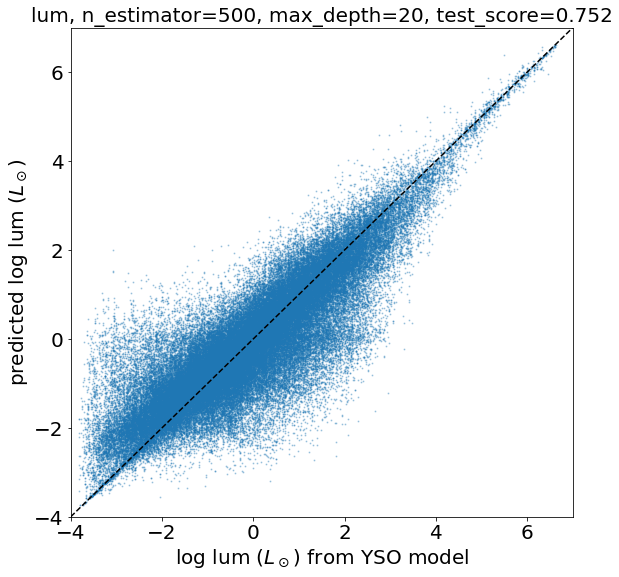

In [6]:
import matplotlib.pyplot as plt
print(model.predict(X_test))
print(y_test)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
plt.rcParams['axes.labelsize']=20

fig = plt.figure(figsize=(9,9))
plt.scatter(y_test, model.predict(X_test),s=1,alpha=0.3)
plt.plot([-4,7],[-4,7], c='k', ls='dashed')
plt.xlim(-4,7)
plt.ylim(-4,7)
plt.xlabel(r'log lum ($L_\odot$) from YSO model')
plt.ylabel(r'predicted log lum ($L_\odot$)')
plt.title('lum, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model.n_estimators,model.max_depth,model.score(X_test, y_test)))
plt.savefig('lum_20_1to1.png')          
          
          

In [8]:
from astropy.table import Table
from scipy.spatial import distance_matrix
from regions import Regions
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse, Circle
from astropy.io import ascii
from itertools import chain
W51 = '/orange/adamginsburg/w51/TaehwaYoo/'
W51b6 = '/orange/adamginsburg/w51/TaehwaYoo/2015.1.01596.S_W51_B6_LB/continuum_images/'
W51cont='/orange/adamginsburg/w51/TaehwaYoo/b6contfits/'

#---------- high res B6 (before conv) ------------
w51e2_b6_briggs=W51cont+'W51e2_cont_bigbriggs.image.fits'
w51e2_b6_robust0=W51cont+'W51e2_cont_big_robust0.image.fits'
w51e2_b6_uniform=W51cont+'W51e2_cont_biguniform.image.fits'
w51e2_b6_superuniform=W51cont+'W51e2_cont_bigsuperuniform.image.fits'

w51n_b6_briggs = W51cont+'W51n_cont_bigbriggs.image.fits'
w51n_b6_robust0 = W51cont+'w51n_cont_big_robust0.image.fits'
w51n_b6_uniform = W51cont+'W51n_cont_biguniform.image.fits'
w51n_b6_superuniform = W51cont+'W51n_cont_bigsuperuniform.image.fits'
w51n_b6_natural = W51cont+'W51n_cont_bignatural.image.fits'

#---------- high res B3 (before conv) ------------

W51b3 = '/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/'

w51n_b3_tt0 = W51b3+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51n_b3_tt1 = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51n_b3_alpha = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51conv = '/orange/adamginsburg/w51/TaehwaYoo/convolved_new/'
w51n_b6_conv = w51conv + 'w51n_cont_bigbriggs.image.convB3_briggs.fits'

w51e_b3_tt0 = W51b3+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51e2_b3_tt1 = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51e2_b3_alpha = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51e2_b6_conv = w51conv + 'w51e2_cont_bigbriggs.image.convB3_briggs.fits'

w51e_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B6_conv.fits'
w51e_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B3_conv.fits'


w51n_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B3_conv.fits'

w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'

w51n_b6_conv_briggs = w51conv + 'w51n_briggs_B6_conv.fits'
w51n_b6_conv_robust0 = w51conv + 'w51n_robust0_B6_conv.fits'
w51n_b6_conv_superuniform = w51conv + 'w51n_superuniform_B6_conv.fits'


w51e_b6_conv_briggs = w51conv + 'w51e_briggs_B6_conv.fits'


#catalogdir = '/Users/dbahck37/w51data/alma_imf/catalog/getsf-native/'
catalogdir = '/orange/adamginsburg/ALMA_IMF/catalogs/getsf-smoothed/'
cat_w51e = catalogdir + 'W51-E-getsf.cat'
cat_w51n = catalogdir + 'W51-IRS2-getsf.cat'


w51n_b3_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_12M_robust0_selfcal4_finaliter.image.tt0.pbcor.fits'
w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'
w51e_b3_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'
w51e_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-E_B6_uid___A001_X1296_X213_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'

w51n_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B3_conv.fits'
w51n_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B6_conv.fits'
w51e_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B3_conv.fits'
w51e_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B6_conv.fits'


w51e_b3_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_b3_rms.reg'
w51e_b6_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_b3_rms.reg'

w51n_b3_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_b3_rms.reg'
w51n_b6_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_b3_rms.reg'


w51e_b3_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51e_b3_std_sky.reg'
w51e_b6_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51e_b6_std_sky.reg'
w51n_b3_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51n_b3_std_sky.reg'
w51n_b6_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51n_b6_std_sky.reg'

def get_flux(image,peakxy, beam1, wcsNB, pixel_scale, major,minor,pa,issky=False,savedir=None, aperture='beam'):
    """
    image : image file from fits
    peakxy = np.vstack((xpos,ypos)).T either pixel or sky coords
    beam1 : beam from header
    wcsNB : wcs from header
    pixel_scale : pixel_scale from header
    major : major axis in deg
    minor : minor axis in deg
    pa : postion angle in deg
    aperture : 'beam' or 'circle'
    """
    beamarea = beam1.sr.value   
    if issky:
        cen_world = peakxy
    else:
        cen_world = wcsNB.wcs_pix2world(peakxy,0)
    num_source = len(cen_world)

    positions = coordinates.SkyCoord(cen_world[0],cen_world[1], frame=wcs.utils.wcs_to_celestial_frame(wcsNB).name,unit=(u.deg,u.deg))
    cutout = Cutout2D(image, positions, 4.0*major, wcs=wcsNB, mode='partial')
    frame = wcs.utils.wcs_to_celestial_frame(cutout.wcs).name
    
    if aperture=='beam':
        aper = Ellipse(positions, major, minor, -1*pa, unit=u.deg, frame=frame) # pa in degree with anti-clockwise direction

    elif aperture=='circle':
        aper = Circle(positions, major, frame=frame, unit=u.deg)
    this_mask = aper.place(cutout.data, wcs=cutout.wcs)
    pixel_scale_sr = (pixel_scale.value * np.pi/180)**2 # pixel scale in deg^2 -> sr
    flux =np.sum(cutout.data[this_mask]/beamarea*pixel_scale_sr) # Jy/beam / (sr/beam) * (sr/pixel) = Jy/ pixel
    
    if savedir is not None:
        if not os.path.isdir(savedir):
            os.mkdir(savedir)
        else:
            fig = plt.figure(figsize=(10,10))
            ax1=fig.add_axes([0.2,0.2,0.8,0.8],projection=wcsNB)
            ax1.imshow(cutout.data, origin='lower')
            ax1.imshow(this_mask, origin='lower',alpha=0.1,cmap='gray')
            plt.savefig(savedir+'aper_%04d.png'%i)
            plt.close()
            
    return flux

def get_flux_aperture(table, datapath, apertures, band='B6'):
    """
    table : catalog table
    imagedata : a path to datafile
    apertures : aperture arrays in au
    band : 'B6' or 'B3'
    """
    x_sky = table['x_sky']
    y_sky = table['y_sky']
    
    numsource = len(x_sky)
    
    fitsdata = fits.open(datapath)
    hdr = fits.getheader(datapath)
    wcsHR = WCS(hdr,naxis=2)
    scale = wcsHR.proj_plane_pixel_scales()[0]
    image = fitsdata[0].data[0][0]
    beamHR = Beam.from_fits_header(hdr)
    
    flux = np.zeros((numsource, len(apertures)))
    for i in range(numsource):
        peakxy = [x_sky[i],y_sky[i]]
        for j, aper in enumerate(apertures):
            
            flux[i,j] = get_flux(image, peakxy, beamHR, wcsHR, scale, aper*u.deg,aper*u.deg, 0, issky=True, aperture='circle') 
            
    return flux
                    
w51e_table = Table.read('/home/t.yoo/w51/catalogue/spectral_index/w51e_combined_catalog.fits')
w51n_table = Table.read('/home/t.yoo/w51/catalogue/spectral_index/w51n_combined_catalog.fits')
w51e_x_sky = w51e_table['x_sky']
w51e_y_sky = w51e_table['y_sky']
w51n_x_sky = w51n_table['x_sky']
w51n_y_sky = w51n_table['y_sky']

apertures_in_au = np.logspace(2,6,20)
apertures_in_au_selected = np.array([apertures_in_au[3], apertures_in_au[4], apertures_in_au[5], apertures_in_au[6]]) 
apertures_in_deg_w51e = apertures_in_au_selected / (5.41e3*206265.) * 180 / np.pi
apertures_in_deg_w51n = apertures_in_au_selected / (5.1e3*206265.) * 180 / np.pi


w51e_b3_flux = get_flux_aperture(w51e_table, w51e_b3_tt0, apertures_in_deg_w51e, band='B3')
w51e_b6_flux = get_flux_aperture(w51e_table, w51e2_b6_briggs, apertures_in_deg_w51e, band='B6')
w51n_b3_flux = get_flux_aperture(w51n_table, w51n_b3_tt0, apertures_in_deg_w51n, band='B3')
w51n_b6_flux = get_flux_aperture(w51n_table, w51n_b6_briggs, apertures_in_deg_w51n, band='B6')

print(w51e_b3_flux)


[[2.92501325e-04 4.97871079e-04 6.65829575e-04 9.20814928e-04]
 [1.02434971e-03 1.73703232e-03 2.45462265e-03 3.34046362e-03]
 [1.82122993e-03 2.85392068e-03 3.54927871e-03 4.27955482e-03]
 [1.35110132e-03 2.51570647e-03 3.98673816e-03 6.54000929e-03]
 [1.28749362e-03 2.34499807e-03 3.67393345e-03 5.98261319e-03]
 [6.47230132e-04 1.28364423e-03 2.67824624e-03 5.80800790e-03]
 [7.60074705e-04 1.60031475e-03 3.13832238e-03 6.31248206e-03]
 [2.70049757e-04 5.79813030e-04 1.26742269e-03 2.45687179e-03]
 [4.53542307e-04 7.41010008e-04 1.03570882e-03 1.49415538e-03]
 [6.65217172e-04 1.39661017e-03 2.60230061e-03 4.94409818e-03]
 [3.53981450e-04 7.62127107e-04 1.41275651e-03 2.56795296e-03]
 [2.42582857e-04 4.52293782e-04 7.97354151e-04 1.51542737e-03]
 [7.95991335e-04 1.58392778e-03 2.95534404e-03 5.70252538e-03]
 [1.06826553e-03 2.31468165e-03 4.54656966e-03 9.30514839e-03]
 [2.23219817e-04 4.47587867e-04 8.35749554e-04 1.50821230e-03]
 [3.27278883e-03 5.96752344e-03 9.12276097e-03 1.403794

In [9]:
def get_min_distances_between_sources(xysources):
    from scipy.spatial import distance_matrix
    
    dist_mat = distance_matrix(xysources,xysources)
    num = dist_mat.shape[0]
    mins = []
    for i in range(num):
        arr = dist_mat[i,:]
        min_dist = np.min(arr[arr>0])
        mins.append(min_dist)
    return np.array(mins)

w51e_xysky = np.vstack((w51e_x_sky,w51e_y_sky)).T

w51e_dist = get_min_distances_between_sources(w51e_xysky)    
w51e_dist_au = w51e_dist * np.pi / 180 * 5.41e3 * 206265.

w51n_xysky = np.vstack((w51n_x_sky,w51n_y_sky)).T

w51n_dist = get_min_distances_between_sources(w51n_xysky)    
w51n_dist_au = w51n_dist * np.pi / 180 * 5.41e3 * 206265.

print(np.min(w51e_dist_au), np.min(w51n_dist_au))
for i in range(w51e_b3_flux.shape[0]):
    b3ind = np.searchsorted(apertures_in_au_selected, w51e_dist_au[i])
    b6ind = np.searchsorted(apertures_in_au_selected, w51e_dist_au[i])
    w51e_b3_flux[i,b3ind+1:]=-1
    w51e_b6_flux[i,b6ind+1:]=-1
    
    print(w51e_dist_au[i], w51e_b3_flux[i,:],w51e_b6_flux[i,:]/w51e_b3_flux[i,:])
    
for i in range(w51n_b3_flux.shape[0]):
    b3ind = np.searchsorted(apertures_in_au_selected, w51n_dist_au[i])
    b6ind = np.searchsorted(apertures_in_au_selected, w51n_dist_au[i])
    w51n_b3_flux[i,b3ind+1:]=-1
    w51n_b6_flux[i,b6ind+1:]=-1


    
def measure_rms(data, noiseregiondir):
    fitsdata = fits.open(data)
    noiseregion= Regions.read(noiseregiondir,format='ds9')
    image = fitsdata[0].data
    wcs = WCS(fitsdata[0].header,naxis=2)

    container = []
    for reg in noiseregion:
        pix_reg = reg.to_pixel(wcs)
        noisemask = pix_reg.to_mask()
        noiseim = noisemask.cutout(image)
        container.append(noiseim.flatten())
    noiseim = list(chain.from_iterable(container))
    std = stats.mad_std(noiseim,ignore_nan=True)
    return std   

360.4678812396529 605.9205693086294
1361.9576025192844 [0.0002925  0.00049787 0.00066583 0.00092081] [ 5.71396606  5.56224408  3.79124922 -3.38481695]
5581.623858941343 [0.00102435 0.00173703 0.00245462 0.00334046] [ 6.91614242  6.95592908  8.26210042 10.98354673]
1446.2119366878226 [0.00182123 0.00285392 0.00354928 0.00427955] [5.09750511 5.33884637 6.45127839 8.93322832]
1061.208373217476 [ 0.0013511   0.00251571  0.00398674 -1.        ] [4.02219738 3.95688947 3.75602348 1.        ]
1061.208373217476 [ 0.00128749  0.002345    0.00367393 -1.        ] [4.7902964  4.88502684 5.53309931 1.        ]
669.2903740469965 [ 6.47230132e-04  1.28364423e-03 -1.00000000e+00 -1.00000000e+00] [5.38257192 4.73807056 1.         1.        ]
708.1199537156833 [ 7.60074705e-04  1.60031475e-03  3.13832238e-03 -1.00000000e+00] [5.30727867 5.19287716 4.79817423 1.        ]
544.4535224398674 [ 2.70049757e-04  5.79813030e-04 -1.00000000e+00 -1.00000000e+00] [8.83235758 7.44174586 1.         1.        ]
5676.5

[0.00054562 0.00111047 0.00163574 0.05436417 0.00269352 0.00152431
 0.00103444 0.00744917 0.00261887 0.01557867 0.00319342 0.00067924
 0.00107249 0.00068396 0.00204441 0.00392831 0.00092348 0.00259834
 0.00232616 0.00306794 0.00219378 0.00268513] [ 9.1664768   5.04051621  1.47529228  1.14027409  6.83795764  9.24907972
  6.56758659  5.12549541  7.07671493  5.08054275  5.48215768  6.60119986
 11.45188587  4.32827312  7.04450011  3.91855111  5.79377266  3.30589289
  4.91074534  4.57025613  5.77609769  3.76755138]


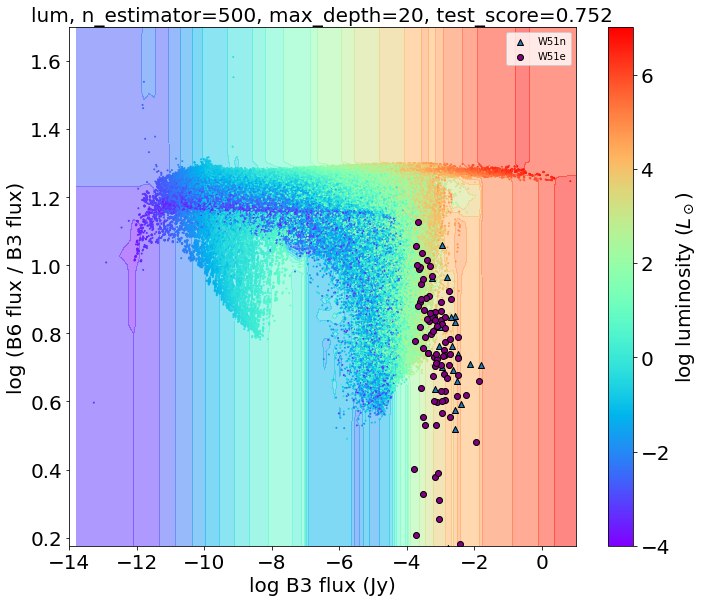

In [16]:
import matplotlib.pyplot as plt

def plot_decision_boundary(ax, model, X, y, alpha=0.5, scatter=True,contour=True, marker=None, vmin=-9,vmax=1.5):
    xx = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
    yy = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)

    XX, YY = np.meshgrid(xx, yy)
    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    cbartick = np.linspace(vmin,vmax,int((vmax-vmin)/0.5)+1)
    if contour:
        ss =ax.contourf(XX, YY, Z, cbartick,alpha=alpha, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
    if scatter:
        if marker == None:
            ss = ax.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
        else:
            ss = ax.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'), marker=marker,vmin=vmin,vmax=vmax)
        
    ax.set_xlabel('log B3 flux (Jy)')
    ax.set_ylabel('log (B6 flux / B3 flux)')
    
    color_bar = plt.colorbar(ss, ax=ax,alpha=1)
    color_bar.set_alpha(1)
    color_bar.draw_all()
    color_bar.set_label('log luminosity ($L_\odot$)')
    
fig= plt.figure(figsize=(11,9)) 
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

plot_decision_boundary(ax1, model, X_train, y_train,vmin=-4,vmax=7)
ax1.scatter(np.log10(w51n_b3_flux[:,0]*(5.41/5.1)**2), np.log10(w51n_b6_flux[:,0]/w51n_b3_flux[:,0]), marker='^',label='W51n',ec='k')
print(w51n_b3_flux[:,0]*(5.41/5.1)**2,w51n_b6_flux[:,0]/w51n_b3_flux[:,0])

ax1.scatter(np.log10(w51e_b3_flux[:,0]), np.log10(w51e_b6_flux[:,0]/w51e_b3_flux[:,0]), marker='o',label='W51e',c='purple',ec='k')
           
ax1.set_xlim(-14,1)
ax1.set_ylim(np.log10(1.5),np.log10(50))
ax1.set_title('lum, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model.n_estimators,model.max_depth,model.score(X_test, y_test)))
plt.legend()
plt.savefig('lum_20_db_wp.png')



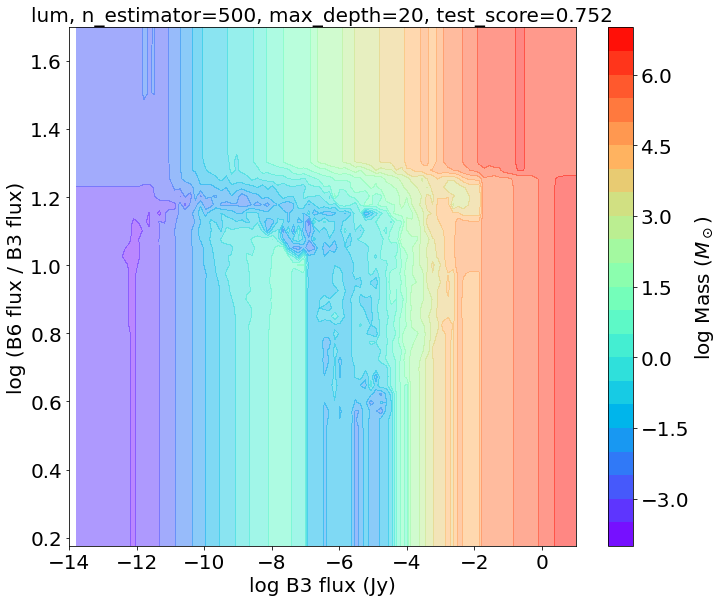

In [15]:
fig= plt.figure(figsize=(11,9)) 
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

plot_decision_boundary(ax1, model, X_train, y_train,vmin=-4,vmax=7,scatter=False)
ax1.set_xlim(-14,1)
ax1.set_ylim(np.log10(1.5),np.log10(50))
ax1.set_title('lum, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model.n_estimators,model.max_depth,model.score(X_test, y_test)))
plt.savefig('lum_20_db_wop.png')

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
index = np.where((np.isfinite(b3fluxarr))&
                 (np.isfinite(b6fluxarr))&
                 (np.isfinite(logmassarr)))[0]
X = np.vstack((b3fluxarr[index], b6fluxarr[index]-b3fluxarr[index])).T
y = logmassarr[index]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [33]:
model = RandomForestRegressor(n_estimators=500, max_depth=5,oob_score=True, n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9357961833912135

[-1.22963822  0.24729867 -2.94621578 ... -2.8293713  -3.73399865
 -2.37881624]
[-1.24139829  0.18250154 -2.92626298 ... -2.80446892 -3.90552115
 -2.43234025]


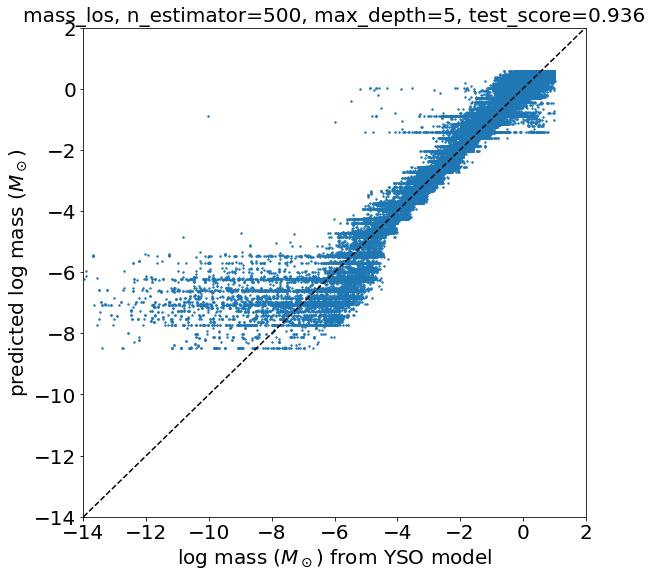

In [34]:
import matplotlib.pyplot as plt
print(model.predict(X_test))
print(y_test)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
plt.rcParams['axes.labelsize']=20

fig = plt.figure(figsize=(9,9))
plt.scatter(y_test, model.predict(X_test),s=2)
plt.plot([-14,2],[-14,2], c='k', ls='dashed')
plt.xlim(-14,2)
plt.ylim(-14,2)
plt.xlabel(r'log mass ($M_\odot$) from YSO model')
plt.ylabel(r'predicted log mass ($M_\odot$)')
plt.title('mass_los, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model.n_estimators,model.max_depth,model.score(X_test, y_test)))
plt.savefig('mass_5_1to1.png')          
          
          

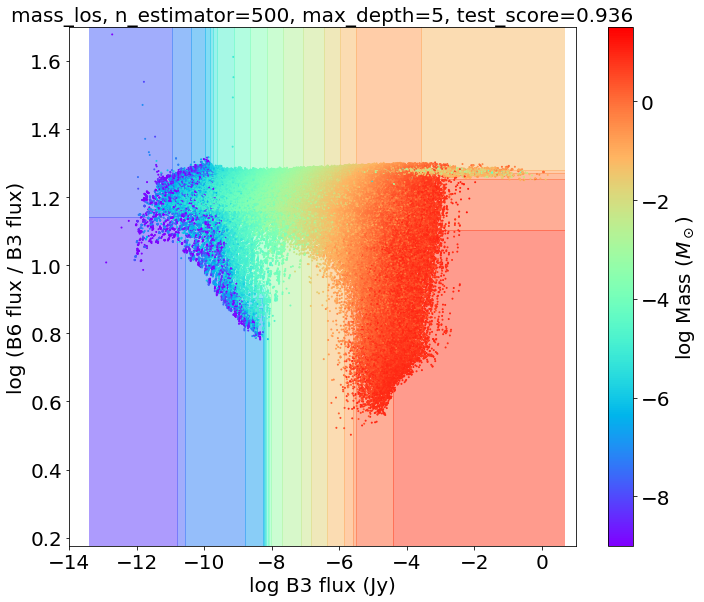

In [54]:
import matplotlib.pyplot as plt

def plot_decision_boundary(ax, model, X, y, alpha=0.5, scatter=True,contour=True, marker=None, vmin=-9,vmax=1.5):
    xx = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
    yy = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)

    XX, YY = np.meshgrid(xx, yy)
    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    cbartick = np.linspace(vmin,vmax,int((vmax-vmin)/0.5)+1)
    if contour:
        ss =ax.contourf(XX, YY, Z, cbartick,alpha=alpha, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
    if scatter:
        if marker == None:
            ss = ax.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
        else:
            ss = ax.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'), marker=marker,vmin=vmin,vmax=vmax)
        
    ax.set_xlabel('log B3 flux (Jy)')
    ax.set_ylabel('log (B6 flux / B3 flux)')
    
    color_bar = plt.colorbar(ss, ax=ax,alpha=1)
    color_bar.set_alpha(1)
    color_bar.draw_all()
    color_bar.set_label('log Mass ($M_\odot$)')
    
fig= plt.figure(figsize=(11,9)) 
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

plot_decision_boundary(ax1, model, X_train, y_train)
ax1.set_xlim(-14,1)
ax1.set_ylim(np.log10(1.5),np.log10(50))
ax1.set_title('mass_los, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model.n_estimators,model.max_depth,model.score(X_test, y_test)))
plt.savefig('mass_5_db_wp.png')



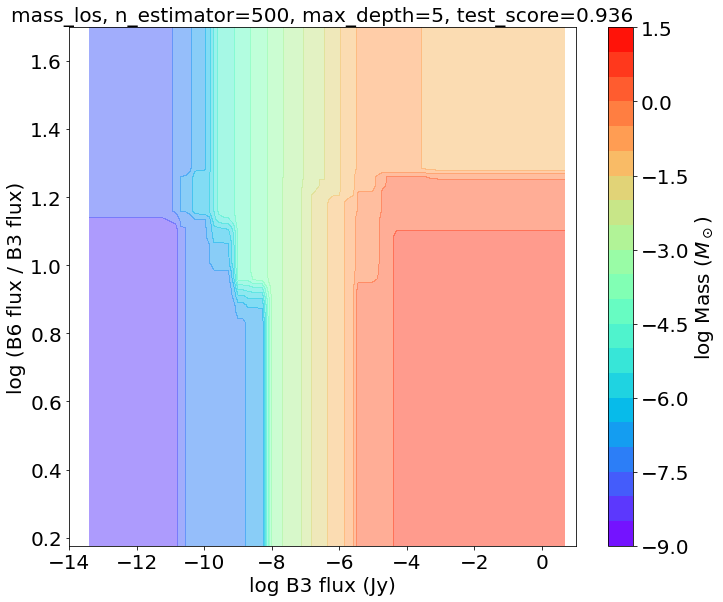

In [56]:

fig= plt.figure(figsize=(11,9))   
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

plot_decision_boundary(ax1,model, X_train, y_train,scatter=False)
ax1.set_xlim(-14,1)
ax1.set_ylim(np.log10(1.5),np.log10(50))
ax1.set_title('mass_los, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model.n_estimators,model.max_depth,model.score(X_test, y_test)))

plt.savefig('mass_5_db_w0p.png')




In [41]:
model2 = RandomForestRegressor(n_estimators=500, max_depth=20, oob_score=True, n_jobs=-1)
model2.fit(X_train, y_train)
model2.score(X_test, y_test)

0.9546569183800866

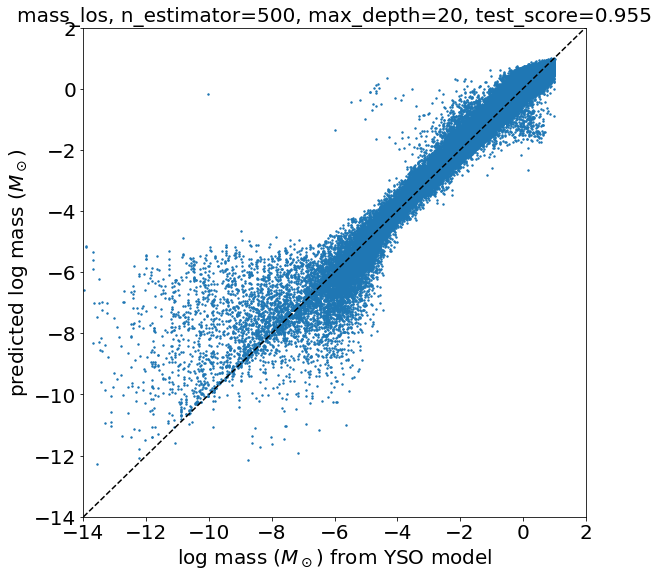

In [42]:

fig = plt.figure(figsize=(9,9))
plt.scatter(y_test, model2.predict(X_test),s=2)
plt.plot([-14,2],[-14,2], c='k', ls='dashed')
plt.xlim(-14,2)
plt.ylim(-14,2)
plt.xlabel(r'log mass ($M_\odot$) from YSO model')
plt.ylabel(r'predicted log mass ($M_\odot$)')
plt.title('mass_los, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model2.n_estimators,model2.max_depth,model2.score(X_test, y_test)))
plt.savefig('mass_20_1to1.png')



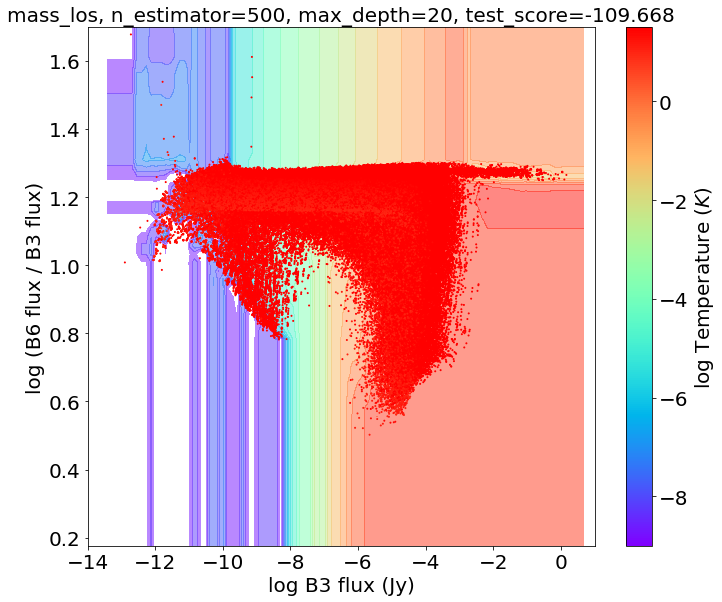

In [71]:

fig= plt.figure(figsize=(11,9))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

plot_decision_boundary(ax1,model2, X_train, y_train)
plt.xlim(-14,1)
plt.ylim(np.log10(1.5),np.log10(50))
plt.title('mass_los, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model2.n_estimators,model2.max_depth,model2.score(X_test, y_test)))

plt.savefig('mass_20_db_wp.png')




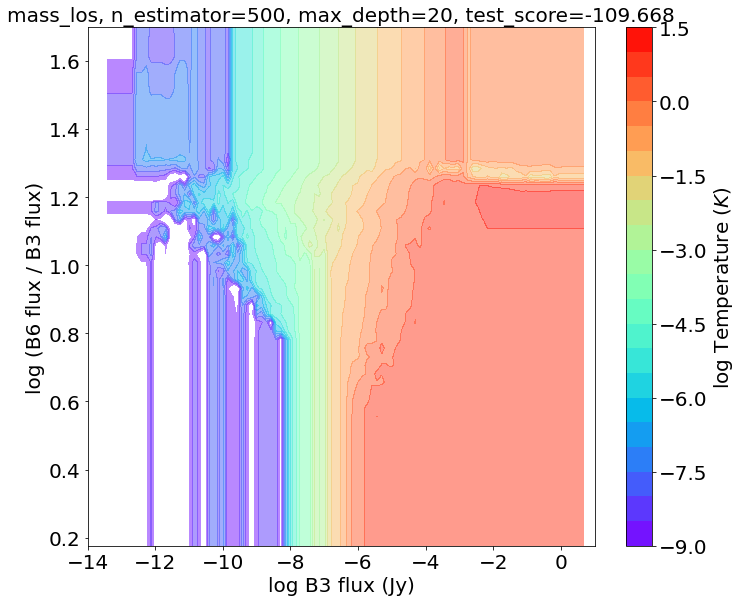

In [72]:

fig= plt.figure(figsize=(11,9))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

plot_decision_boundary(ax1, model2, X_train, y_train,scatter=False)
plt.xlim(-14,1)
plt.ylim(np.log10(1.5),np.log10(50))
plt.title('mass_los, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model2.n_estimators,model2.max_depth,model2.score(X_test, y_test)))

plt.savefig('mass_20_db_wop.png')




In [62]:
index = np.where((np.isfinite(b3fluxarr))&
                 (np.isfinite(b6fluxarr))&
                 (np.isfinite(logtemparr)))[0]
X = np.vstack((b3fluxarr[index], b6fluxarr[index]-b3fluxarr[index])).T
y2 = logtemparr[index]
X_train, X_test, y_train, y_test = train_test_split(X, y2, random_state=0)
model3 = RandomForestRegressor(n_estimators=500, max_depth=20,oob_score=True, n_jobs=-1)
model3.fit(X_train, y_train)
model3.score(X_test, y_test)

0.2952022139588517

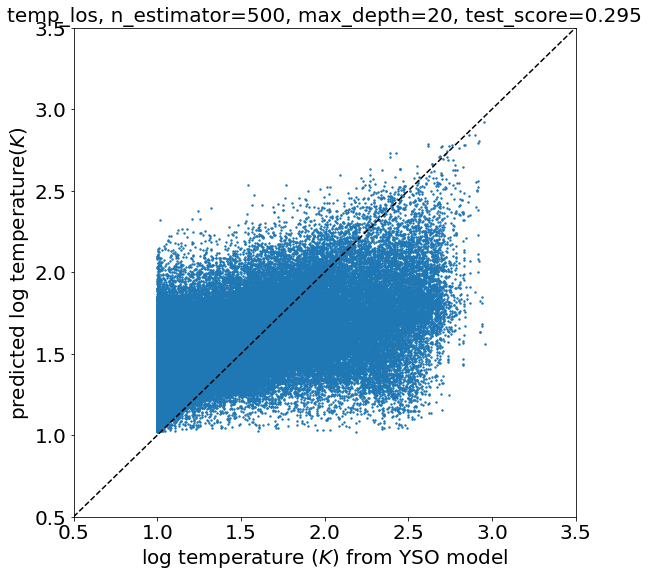

In [66]:


fig = plt.figure(figsize=(9,9))
plt.scatter(y_test, model3.predict(X_test),s=2)
plt.plot([0.5,3.5],[0.5,3.5], c='k', ls='dashed')
plt.xlim(0.5,3.5)
plt.ylim(0.5,3.5)
plt.xlabel(r'log temperature ($K$) from YSO model')
plt.ylabel(r'predicted log temperature($K$)')
plt.title('temp_los, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model3.n_estimators,model3.max_depth,model3.score(X_test, y_test)))
plt.savefig('temp_20_1to1.png')



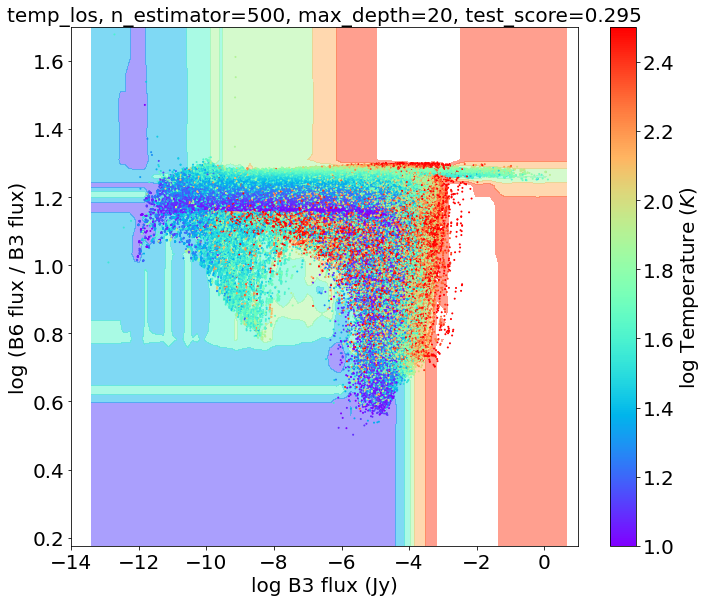

In [77]:
def plot_decision_boundary(ax, model, X, y, alpha=0.5, interval=0.5,scatter=True,contour=True, marker=None, vmin=-9,vmax=1.5):
    xx = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
    yy = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)

    XX, YY = np.meshgrid(xx, yy)
    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    cbartick = np.linspace(vmin,vmax,int((vmax-vmin)/interval)+1)
    if contour:
        ss =ax.contourf(XX, YY, Z, cbartick,alpha=alpha, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
    if scatter:
        if marker == None:
            ss = ax.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
        else:
            ss = ax.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'), marker=marker,vmin=vmin,vmax=vmax)
        
    ax.set_xlabel('log B3 flux (Jy)')
    ax.set_ylabel('log (B6 flux / B3 flux)')
    
    color_bar = plt.colorbar(ss, ax=ax,alpha=1)
    color_bar.set_alpha(1)
    color_bar.draw_all()
    color_bar.set_label('log Temperature ($K$)')
    
fig= plt.figure(figsize=(11,9))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

plot_decision_boundary(ax1,model3, X_train, y_train,vmin=1,vmax=2.5,interval=0.25)
ax1.set_xlim(-14,1)
ax1.set_ylim(np.log10(1.5),np.log10(50))
plt.title('temp_los, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model3.n_estimators,model3.max_depth,model3.score(X_test, y_test)))
plt.savefig('temp_20_db_wp.png')



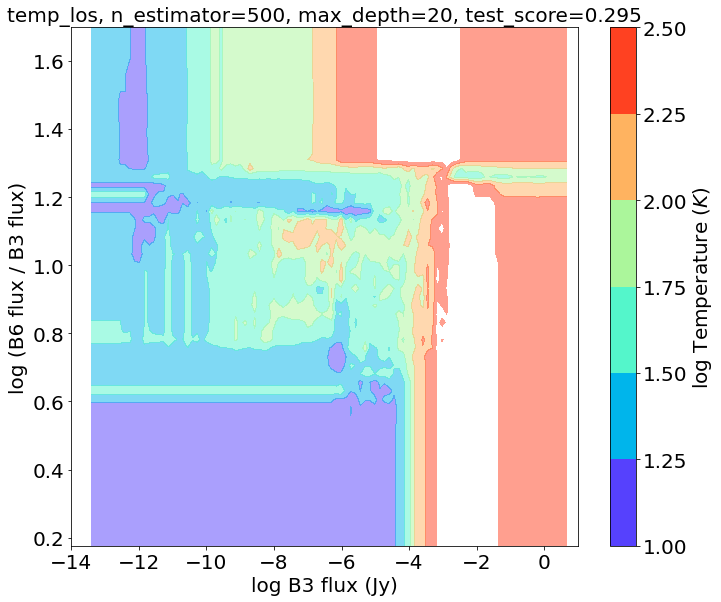

In [78]:

fig= plt.figure(figsize=(11,9))   
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

plot_decision_boundary(ax1,model3, X_train, y_train,scatter=False,vmin=1,vmax=2.5,interval=0.25)
plt.xlim(-14,1)
plt.ylim(np.log10(1.5),np.log10(50))
plt.title('temp_los, n_estimator=%d, max_depth=%d, test_score=%4.3f'%(model3.n_estimators,model3.max_depth,model3.score(X_test, y_test)))
plt.savefig('temp_20_db_wop.png')



In [79]:
model4 = RandomForestRegressor(n_estimators=500, max_depth=50, oob_score=True, n_jobs=-1)
model4.fit(X_train, y_train)
model4.score(X_test, y_test)

0.2419412361969594

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   19.2s finished


Text(0.5, 1.0, 'mass_los, n_estimator=2000, max_depth=9')

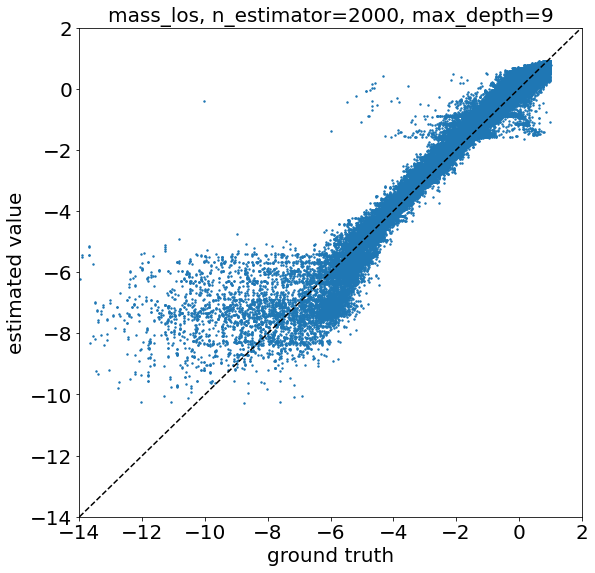

In [96]:

plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
plt.rcParams['axes.labelsize']=20

fig = plt.figure(figsize=(9,9))
plt.scatter(y_test, model4.predict(X_test),s=2)
plt.plot([-14,2],[-14,2], c='k', ls='dashed')
plt.xlim(-14,2)
plt.ylim(-14,2)
plt.xlabel('ground truth')
plt.ylabel('estimated value')
plt.title('mass_los, n_estimator=2000, max_depth=9')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.0s finished


(0.17609125905568124, 1.6989700043360187)

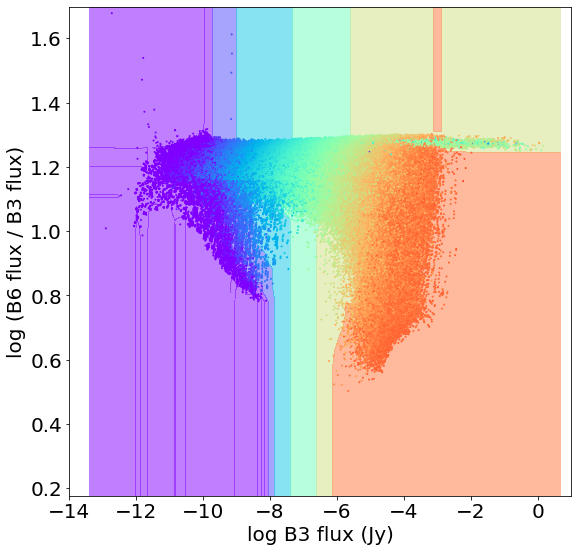

In [97]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, alpha=0.5, scatter=True,contour=True, marker=None, vmin=-6,vmax=2):
    xx = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
    yy = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)

    XX, YY = np.meshgrid(xx, yy)
    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)

    if contour:
        plt.contourf(XX, YY, Z, alpha=alpha, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
    if scatter:
        if marker == None:
            plt.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
        else:
            plt.scatterter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'), marker=marker,vmin=vmin,vmax=vmax)
        
    plt.xlabel('log B3 flux (Jy)')
    plt.ylabel('log (B6 flux / B3 flux)')
    
fig= plt.figure(figsize=(9,9))   
plot_decision_boundary(model4, X_train, y_train)
plt.xlim(-14,1)
plt.ylim(np.log10(1.5),np.log10(50))




In [2]:
import glob
import os
from astropy.io import fits
import numpy as np

pathlist = glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.1/s*')
geometry = [os.path.basename(path).split('/')[-1][:7] for path in pathlist]

b3fluxarr = np.array([]) ; b6b3fluxarr = np.array([])
logmassarr = np.array([])
for path in geometry:
    filepath = './'+path+'/flux_prop.fits'
    if not os.path.isfile(filepath):
        continue
    fluxfile = fits.open(filepath)
    cols = fluxfile[1].columns
    if not 'mass_los' in cols.names:
        continue
    print(path)
    

    b6flux = fluxfile[1].data['b6 flux'][:,3]*1e-3*(1/5.41)**2
    b3flux = fluxfile[1].data['b3 flux'][:,3]*1e-3*(1/5.41)**2
    
    
    
    masslos = fluxfile[1].data['mass_los'][:,3]
    logmass = np.log10(masslos)

    index = np.where((masslos>0)&(b6flux>0)&(b3flux>0)&(np.isnan(logmass)==False)&(np.isnan(b6flux)==False)&(np.isnan(b3flux)==False))[0]
    masslos = masslos[index]
    logmass = logmass[index]
    
    logb3flux = np.log10(b3flux[index]) 
    logb6b3flux = np.log10(b6flux[index]/b3flux[index])
    b3fluxarr = np.append(b3fluxarr, logb3flux)
    b6b3fluxarr = np.append(b6b3fluxarr, logb6b3flux)
    
    
    logmassarr = np.append(logmassarr, logmass)
    
b3fluxarr.flatten()
b6b3fluxarr.flatten()
logmassarr.flatten()
X = np.vstack((b3fluxarr, b6b3fluxarr)).T
y = logmassarr




s-pbsmi
s-p-hmi
spu-hmi
spubsmi


/scratch/local/62374029/ipykernel_779/3995504572.py:28: RuntimeWarning: invalid value encountered in log10
  logmass = np.log10(masslos)
/scratch/local/62374029/ipykernel_779/3995504572.py:28: RuntimeWarning: divide by zero encountered in log10
  logmass = np.log10(masslos)


s-pbhmi
s-u-smi
s-ubhmi
spu-smi
s-u-hmi
s-ubsmi
spubhmi
s-p-smi


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [15]:
model5 = RandomForestRegressor(n_estimators=2000, max_depth=13, verbose=3,oob_score=True, n_jobs=-1)
model5.fit(X_train, y_train)
model5.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 2000


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 2000


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 2000
building tree 4 of 2000
building tree 5 of 2000
building tree 6 of 2000
building tree 7 of 2000
building tree 8 of 2000
building tree 9 of 2000
building tree 10 of 2000
building tree 11 of 2000
building tree 12 of 2000
building tree 13 of 2000
building tree 14 of 2000
building tree 15 of 2000
building tree 16 of 2000
building tree 17 of 2000
building tree 18 of 2000
building tree 19 of 2000
building tree 20 of 2000
building tree 21 of 2000
building tree 22 of 2000
building tree 23 of 2000
building tree 24 of 2000
building tree 25 of 2000
building tree 26 of 2000
building tree 27 of 2000
building tree 28 of 2000
building tree 29 of 2000
building tree 30 of 2000
building tree 31 of 2000
building tree 32 of 2000
building tree 33 of 2000
building tree 34 of 2000
building tree 35 of 2000
building tree 36 of 2000
building tree 37 of 2000
building tree 38 of 2000
building tree 39 of 2000
building tree 40 of 2000
building tree 41 of 2000
building tree 42 of 2000
buildin

[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 18.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   28.0s finished


0.9526818843868043

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   28.5s finished


Text(0.5, 1.0, 'mass_los, n_estimator=2000, max_depth=5')

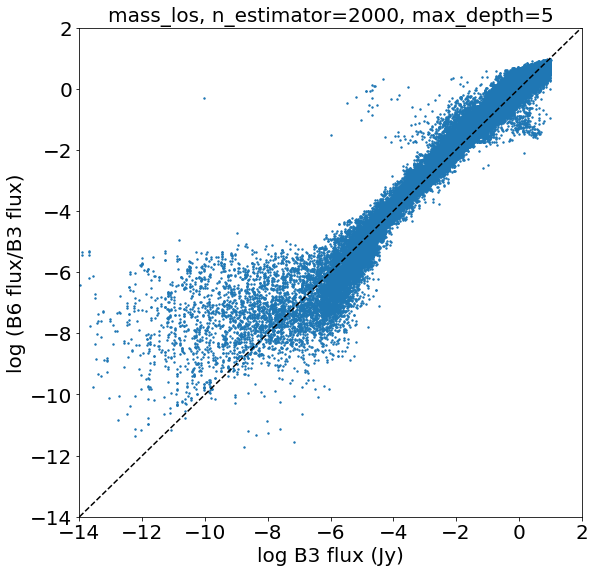

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
plt.rcParams['axes.labelsize']=20

fig = plt.figure(figsize=(9,9))
plt.scatter(y_test, model5.predict(X_test),s=2)
plt.plot([-14,2],[-14,2], c='k', ls='dashed')
plt.xlim(-14,2)
plt.ylim(-14,2)
plt.xlabel('log B3 flux (Jy)')
plt.ylabel('log (B6 flux/B3 flux)')
plt.title('mass_los, n_estimator=2000, max_depth=5')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.2s finished


(0.17609125905568124, 1.6989700043360187)

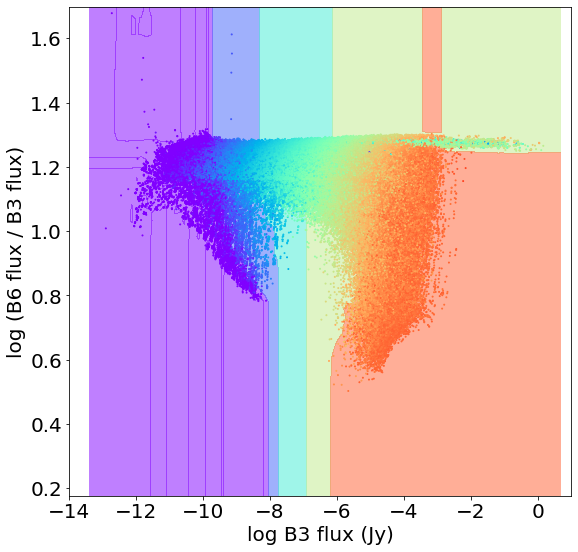

In [17]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, alpha=0.5, scatter=True,contour=True, marker=None, vmin=-6,vmax=2):
    xx = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
    yy = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)

    XX, YY = np.meshgrid(xx, yy)
    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)

    if contour:
        plt.contourf(XX, YY, Z, alpha=alpha, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
    if scatter:
        if marker == None:
            plt.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'),vmin=vmin,vmax=vmax)
        else:
            plt.scatterter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.get_cmap('rainbow'), marker=marker,vmin=vmin,vmax=vmax)
        
    plt.xlabel('log B3 flux (Jy)')
    plt.ylabel('log (B6 flux / B3 flux)')
    
fig= plt.figure(figsize=(9,9))   
plot_decision_boundary(model5, X_train, y_train)
plt.xlim(-14,1)
plt.ylim(np.log10(1.5),np.log10(50))




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.3s finished


(0.17609125905568124, 1.6989700043360187)

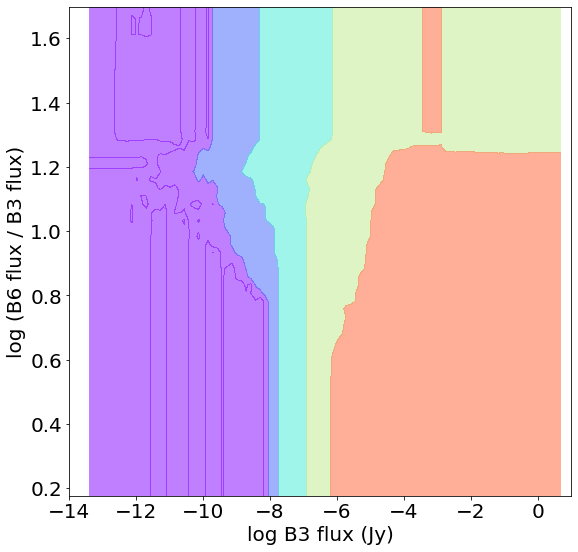

In [18]:
fig= plt.figure(figsize=(9,9))   
plot_decision_boundary(model5, X_train, y_train,scatter=False)
plt.xlim(-14,1)
plt.ylim(np.log10(1.5),np.log10(50))

In [ ]:
model6 = RandomForestRegressor(n_estimators=1000, max_depth=20, verbose=3,oob_score=True, n_jobs=-1)
model6.fit(X_train, y_train)
model6.score(X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
plt.rcParams['axes.labelsize']=20

fig = plt.figure(figsize=(9,9))
plt.scatter(y_test, model6.predict(X_test),s=2)
plt.plot([-14,2],[-14,2], c='k', ls='dashed')
plt.xlim(-14,2)
plt.ylim(-14,2)
plt.xlabel('log B3 flux (Jy)')
plt.ylabel('log (B6 flux/B3 flux)')
plt.title('mass_los, n_estimator=2000, max_depth=30')

In [ ]:
    
fig= plt.figure(figsize=(9,9))   
plot_decision_boundary(model6, X_train, y_train)
plt.xlim(-14,1)
plt.ylim(np.log10(1.5),np.log10(50))


In [ ]:
    
fig= plt.figure(figsize=(9,9))   
plot_decision_boundary(model6, X_train, y_train,scatter=False)
plt.xlim(-14,1)
plt.ylim(np.log10(1.5),np.log10(50))


In [90]:

from astropy.table import Table
from scipy.spatial import distance_matrix
from regions import Regions
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse, Circle
from astropy.io import ascii
from itertools import chain

#%load_ext memory_profiler
#from test import plot_flux_comp
W51 = '/orange/adamginsburg/w51/TaehwaYoo/'
W51b6 = '/orange/adamginsburg/w51/TaehwaYoo/2015.1.01596.S_W51_B6_LB/continuum_images/'
W51cont='/orange/adamginsburg/w51/TaehwaYoo/b6contfits/'

#---------- high res B6 (before conv) ------------
w51e2_b6_briggs=W51cont+'W51e2_cont_bigbriggs.image.fits'
w51e2_b6_robust0=W51cont+'W51e2_cont_big_robust0.image.fits'
w51e2_b6_uniform=W51cont+'W51e2_cont_biguniform.image.fits'
w51e2_b6_superuniform=W51cont+'W51e2_cont_bigsuperuniform.image.fits'

w51n_b6_briggs = W51cont+'W51n_cont_bigbriggs.image.fits'
w51n_b6_robust0 = W51cont+'w51n_cont_big_robust0.image.fits'
w51n_b6_uniform = W51cont+'W51n_cont_biguniform.image.fits'
w51n_b6_superuniform = W51cont+'W51n_cont_bigsuperuniform.image.fits'
w51n_b6_natural = W51cont+'W51n_cont_bignatural.image.fits'

#---------- high res B3 (before conv) ------------

W51b3 = '/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/'

w51n_b3_tt0 = W51b3+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51n_b3_tt1 = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51n_b3_alpha = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51conv = '/orange/adamginsburg/w51/TaehwaYoo/convolved_new/'
w51n_b6_conv = w51conv + 'w51n_cont_bigbriggs.image.convB3_briggs.fits'

w51e_b3_tt0 = W51b3+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51e2_b3_tt1 = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51e2_b3_alpha = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51e2_b6_conv = w51conv + 'w51e2_cont_bigbriggs.image.convB3_briggs.fits'

w51e_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B6_conv.fits'
w51e_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B3_conv.fits'


w51n_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B3_conv.fits'

w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'

w51n_b6_conv_briggs = w51conv + 'w51n_briggs_B6_conv.fits'
w51n_b6_conv_robust0 = w51conv + 'w51n_robust0_B6_conv.fits'
w51n_b6_conv_superuniform = w51conv + 'w51n_superuniform_B6_conv.fits'


w51e_b6_conv_briggs = w51conv + 'w51e_briggs_B6_conv.fits'


#catalogdir = '/Users/dbahck37/w51data/alma_imf/catalog/getsf-native/'
catalogdir = '/orange/adamginsburg/ALMA_IMF/catalogs/getsf-smoothed/'
cat_w51e = catalogdir + 'W51-E-getsf.cat'
cat_w51n = catalogdir + 'W51-IRS2-getsf.cat'


w51n_b3_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_12M_robust0_selfcal4_finaliter.image.tt0.pbcor.fits'
w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'
w51e_b3_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'
w51e_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-E_B6_uid___A001_X1296_X213_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'

w51n_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B3_conv.fits'
w51n_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B6_conv.fits'
w51e_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B3_conv.fits'
w51e_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B6_conv.fits'


w51e_b3_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_b3_rms.reg'
w51e_b6_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_b3_rms.reg'

w51n_b3_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_b3_rms.reg'
w51n_b6_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_b3_rms.reg'


w51e_b3_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51e_b3_std_sky.reg'
w51e_b6_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51e_b6_std_sky.reg'
w51n_b3_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51n_b3_std_sky.reg'
w51n_b6_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51n_b6_std_sky.reg'

#---------- local direc  ------------

"""

w51n_b3_almaimf = '/Users/dbahck37/w51data/alma_imf/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_12M_robust0_selfcal4_finaliter.image.tt0.pbcor.fits'
w51n_b6_almaimf = '/Users/dbahck37/w51data/alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'



w51e_b3_almaimf = '/Users/dbahck37/w51data/alma_imf/W51-E_B3_uid___A001"X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'
w51e_b6_almaimf = '/Users/dbahck37/w51data/alma_imf/W51-E_B6_uid___A001_X1296_X213_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'


w51n_b6_conv_briggs = '/Users/dbahck37/w51data/convolved_new/w51n_briggs_B6_conv.fits'
w51n_b3_tt0 = '/Users/dbahck37/w51data/w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'

w51e_b3_tt0 = '/Users/dbahck37/W51data/w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'

w51e_b6_conv_briggs ='/Users/dbahck37/W51data/convolved_new/w51e_briggs_B6_conv.fits'
"""


def get_flux(image,peakxy, beam1, wcsNB, pixel_scale, major,minor,pa,issky=False,savedir=None, aperture='beam'):
    """
    image : image file from fits
    peakxy = np.vstack((xpos,ypos)).T either pixel or sky coords
    beam1 : beam from header
    wcsNB : wcs from header
    pixel_scale : pixel_scale from header
    major : major axis in deg
    minor : minor axis in deg
    pa : postion angle in deg
    aperture : 'beam' or 'circle'
    """
    beamarea = beam1.sr.value   
    if issky:
        cen_world = peakxy
    else:
        cen_world = wcsNB.wcs_pix2world(peakxy,0)
    num_source = len(cen_world)

    positions = coordinates.SkyCoord(cen_world[0],cen_world[1], frame=wcs.utils.wcs_to_celestial_frame(wcsNB).name,unit=(u.deg,u.deg))
    cutout = Cutout2D(image, positions, 4.0*major, wcs=wcsNB, mode='partial')
    frame = wcs.utils.wcs_to_celestial_frame(cutout.wcs).name
    
    if aperture=='beam':
        aper = Ellipse(positions, major, minor, -1*pa, unit=u.deg, frame=frame) # pa in degree with anti-clockwise direction

    elif aperture=='circle':
        aper = Circle(positions, major, frame=frame, unit=u.deg)
    this_mask = aper.place(cutout.data, wcs=cutout.wcs)
    pixel_scale_sr = (pixel_scale.value * np.pi/180)**2 # pixel scale in deg^2 -> sr
    flux =np.sum(cutout.data[this_mask]/beamarea*pixel_scale_sr) # Jy/beam / (sr/beam) * (sr/pixel) = Jy/ pixel
    
    if savedir is not None:
        if not os.path.isdir(savedir):
            os.mkdir(savedir)
        else:
            fig = plt.figure(figsize=(10,10))
            ax1=fig.add_axes([0.2,0.2,0.8,0.8],projection=wcsNB)
            ax1.imshow(cutout.data, origin='lower')
            ax1.imshow(this_mask, origin='lower',alpha=0.1,cmap='gray')
            plt.savefig(savedir+'aper_%04d.png'%i)
            plt.close()
            
    return flux

def get_flux_aperture(table, datapath, apertures, band='B6'):
    """
    table : catalog table
    imagedata : a path to datafile
    apertures : aperture arrays in au
    band : 'B6' or 'B3'
    """
    x_sky = table['x_sky']
    y_sky = table['y_sky']
    
    numsource = len(x_sky)
    
    fitsdata = fits.open(datapath)
    hdr = fits.getheader(datapath)
    wcsHR = WCS(hdr,naxis=2)
    scale = wcsHR.proj_plane_pixel_scales()[0]
    image = fitsdata[0].data[0][0]
    beamHR = Beam.from_fits_header(hdr)
    
    flux = np.zeros((numsource, len(apertures)))
    for i in range(numsource):
        peakxy = [x_sky[i],y_sky[i]]
        for j, aper in enumerate(apertures):
            
            flux[i,j] = get_flux(image, peakxy, beamHR, wcsHR, scale, aper*u.deg,aper*u.deg, 0, issky=True, aperture='circle') 
            
    return flux
                    
w51e_table = Table.read('/home/t.yoo/w51/catalogue/spectral_index/w51e_combined_catalog.fits')
w51n_table = Table.read('/home/t.yoo/w51/catalogue/spectral_index/w51n_combined_catalog.fits')
w51e_x_sky = w51e_table['x_sky']
w51e_y_sky = w51e_table['y_sky']
w51n_x_sky = w51n_table['x_sky']
w51n_y_sky = w51n_table['y_sky']

apertures_in_au = np.logspace(2,6,20)
apertures_in_au_selected = np.array([apertures_in_au[3], apertures_in_au[4], apertures_in_au[5], apertures_in_au[6]]) 
apertures_in_deg_w51e = apertures_in_au_selected / (5.41e3*206265.) * 180 / np.pi
apertures_in_deg_w51n = apertures_in_au_selected / (5.1e3*206265.) * 180 / np.pi


w51e_b3_flux = get_flux_aperture(w51e_table, w51e_b3_tt0, apertures_in_deg_w51e, band='B3')
w51e_b6_flux = get_flux_aperture(w51e_table, w51e2_b6_briggs, apertures_in_deg_w51e, band='B6')
w51n_b3_flux = get_flux_aperture(w51n_table, w51n_b3_tt0, apertures_in_deg_w51n, band='B3')
w51n_b6_flux = get_flux_aperture(w51n_table, w51n_b6_briggs, apertures_in_deg_w51n, band='B6')

print(w51e_b3_flux)





[[2.92501325e-04 4.97871079e-04 6.65829575e-04 9.20814928e-04]
 [1.02434971e-03 1.73703232e-03 2.45462265e-03 3.34046362e-03]
 [1.82122993e-03 2.85392068e-03 3.54927871e-03 4.27955482e-03]
 [1.35110132e-03 2.51570647e-03 3.98673816e-03 6.54000929e-03]
 [1.28749362e-03 2.34499807e-03 3.67393345e-03 5.98261319e-03]
 [6.47230132e-04 1.28364423e-03 2.67824624e-03 5.80800790e-03]
 [7.60074705e-04 1.60031475e-03 3.13832238e-03 6.31248206e-03]
 [2.70049757e-04 5.79813030e-04 1.26742269e-03 2.45687179e-03]
 [4.53542307e-04 7.41010008e-04 1.03570882e-03 1.49415538e-03]
 [6.65217172e-04 1.39661017e-03 2.60230061e-03 4.94409818e-03]
 [3.53981450e-04 7.62127107e-04 1.41275651e-03 2.56795296e-03]
 [2.42582857e-04 4.52293782e-04 7.97354151e-04 1.51542737e-03]
 [7.95991335e-04 1.58392778e-03 2.95534404e-03 5.70252538e-03]
 [1.06826553e-03 2.31468165e-03 4.54656966e-03 9.30514839e-03]
 [2.23219817e-04 4.47587867e-04 8.35749554e-04 1.50821230e-03]
 [3.27278883e-03 5.96752344e-03 9.12276097e-03 1.403794

In [91]:
def get_min_distances_between_sources(xysources):
    from scipy.spatial import distance_matrix
    
    dist_mat = distance_matrix(xysources,xysources)
    num = dist_mat.shape[0]
    mins = []
    for i in range(num):
        arr = dist_mat[i,:]
        min_dist = np.min(arr[arr>0])
        mins.append(min_dist)
    return np.array(mins)

w51e_xysky = np.vstack((w51e_x_sky,w51e_y_sky)).T

w51e_dist = get_min_distances_between_sources(w51e_xysky)    
w51e_dist_au = w51e_dist * np.pi / 180 * 5.41e3 * 206265.

w51n_xysky = np.vstack((w51n_x_sky,w51n_y_sky)).T

w51n_dist = get_min_distances_between_sources(w51n_xysky)    
w51n_dist_au = w51n_dist * np.pi / 180 * 5.41e3 * 206265.

print(np.min(w51e_dist_au), np.min(w51n_dist_au))
for i in range(w51e_b3_flux.shape[0]):
    b3ind = np.searchsorted(apertures_in_au_selected, w51e_dist_au[i])
    b6ind = np.searchsorted(apertures_in_au_selected, w51e_dist_au[i])
    w51e_b3_flux[i,b3ind+1:]=-1
    w51e_b6_flux[i,b6ind+1:]=-1
    
    print(w51e_dist_au[i], w51e_b3_flux[i,:],w51e_b6_flux[i,:]/w51e_b3_flux[i,:])
    
for i in range(w51n_b3_flux.shape[0]):
    b3ind = np.searchsorted(apertures_in_au_selected, w51n_dist_au[i])
    b6ind = np.searchsorted(apertures_in_au_selected, w51n_dist_au[i])
    w51n_b3_flux[i,b3ind+1:]=-1
    w51n_b6_flux[i,b6ind+1:]=-1


    
def measure_rms(data, noiseregiondir):
    fitsdata = fits.open(data)
    noiseregion= Regions.read(noiseregiondir,format='ds9')
    image = fitsdata[0].data
    wcs = WCS(fitsdata[0].header,naxis=2)

    container = []
    for reg in noiseregion:
        pix_reg = reg.to_pixel(wcs)
        noisemask = pix_reg.to_mask()
        noiseim = noisemask.cutout(image)
        container.append(noiseim.flatten())
    noiseim = list(chain.from_iterable(container))
    std = stats.mad_std(noiseim,ignore_nan=True)
    return std   

360.4678812396529 605.9205693086294
1361.9576025192844 [0.0002925  0.00049787 0.00066583 0.00092081] [ 5.71396606  5.56224408  3.79124922 -3.38481695]
5581.623858941343 [0.00102435 0.00173703 0.00245462 0.00334046] [ 6.91614242  6.95592908  8.26210042 10.98354673]
1446.2119366878226 [0.00182123 0.00285392 0.00354928 0.00427955] [5.09750511 5.33884637 6.45127839 8.93322832]
1061.208373217476 [ 0.0013511   0.00251571  0.00398674 -1.        ] [4.02219738 3.95688947 3.75602348 1.        ]
1061.208373217476 [ 0.00128749  0.002345    0.00367393 -1.        ] [4.7902964  4.88502684 5.53309931 1.        ]
669.2903740469965 [ 6.47230132e-04  1.28364423e-03 -1.00000000e+00 -1.00000000e+00] [5.38257192 4.73807056 1.         1.        ]
708.1199537156833 [ 7.60074705e-04  1.60031475e-03  3.13832238e-03 -1.00000000e+00] [5.30727867 5.19287716 4.79817423 1.        ]
544.4535224398674 [ 2.70049757e-04  5.79813030e-04 -1.00000000e+00 -1.00000000e+00] [8.83235758 7.44174586 1.         1.        ]
5676.5

In [98]:
w51n_b3_flux_1d = w51n_b3_flux[:,0]*(5.41/5.1)**2
w51e_b3_flux_1d = w51e_b3_flux[:,0]

w51e_b6_flux_1d = w51e_b6_flux[:,0]
w51n_b6_flux_1d = w51n_b6_flux[:,0]*(5.41/5.1)**2

logy_w51n = np.log10(w51n_b6_flux_1d/w51n_b3_flux_1d)
logx_w51n = np.log10(w51n_b3_flux_1d)
logy_w51e = np.log10(w51e_b6_flux_1d/w51e_b3_flux_1d)
logx_w51e = np.log10(w51e_b3_flux_1d)

select_ind_w51n = np.where(
    (logy_w51n - np.log10(6/1)/np.log10(5e-3/1e-8)*logx_w51n > (np.log10(5e-3)*np.log10(1)-np.log10(1e-8)*np.log10(6))/(np.log10(5e-3/1e-8)))
     & (logx_w51n < np.log10(5e-3))
     & (logy_w51n < np.log10(20)))[0]
                                                                                                                         
     
select_ind_w51e = np.where(
    (logy_w51e - np.log10(6/1)/np.log10(5e-3/1e-8)*logx_w51e > (np.log10(5e-3)*np.log10(1)-np.log10(1e-8)*np.log10(6))/(np.log10(5e-3/1e-8)))
     & (logx_w51e < np.log10(5e-3))
     & (logy_w51e < np.log10(20)))[0]
print(select_ind_w51n)
print(select_ind_w51e)
print(len(w51n_b3_flux_selected),len(w51n_b3_flux_1d))
print(len(w51e_b3_flux_selected),len(w51e_b3_flux_1d))

w51n_b3_flux_selected = w51n_b3_flux_1d[select_ind_w51n]
w51n_b6_flux_selected = w51n_b6_flux_1d[select_ind_w51n]

    
w51e_b3_flux_selected = w51e_b3_flux_1d[select_ind_w51e]
w51e_b6_flux_selected = w51e_b6_flux_1d[select_ind_w51e]



[ 0  1  4  5  6  8 11 12 14 16 20]
[ 0  1  5  6  7  8  9 10 11 14 16 18 19 21 22 23 26 27 28 29 30 35 36 38
 39 40 42 43 45 46 47 48 49 50 51 52 53 54 55 67 68 70 72 74 75 81 84 86
 88 89 90 91 92 93 94 95 96]
11 22
57 97


[0.00167134 0.00708455 0.00348376 0.00403393 0.00238518 0.00310563
 0.00336119 0.00218656 0.00160278 0.00218468 0.00511328 0.00377887
 0.01606384 0.00713401 0.00817554 0.01525322 0.00243986 0.00683626
 0.00281327 0.00471488 0.00821083 0.02009671 0.00753722 0.00278304
 0.00493129 0.00200946 0.00189398 0.00857597 0.00244349 0.00229849
 0.00448665 0.0039747  0.00969125 0.00373944 0.00473511 0.0052567
 0.00534861 0.00301352 0.00760837 0.00115935 0.00379955 0.01047342
 0.00107124 0.00211829 0.00626169 0.01117873 0.00239252 0.00159266
 0.00354519 0.00411581 0.00272828 0.00210971 0.00316767 0.0039578
 0.00371794 0.00306799 0.00265804] [ 0.85742845  3.63449913  1.78723212  2.06947681  1.22363764  1.59324245
  1.72434797  1.12174652  0.82225439  1.12078187  2.62320432  1.93862786
  8.24103275  3.65987525  4.19419847  7.82517393  1.25169067  3.50712379
  1.44325666  2.41881912  4.21230222 10.30996991  3.86672821  1.42774871
  2.52983748  1.03089033  0.9716454   4.39962596  1.25355498  1.17916768

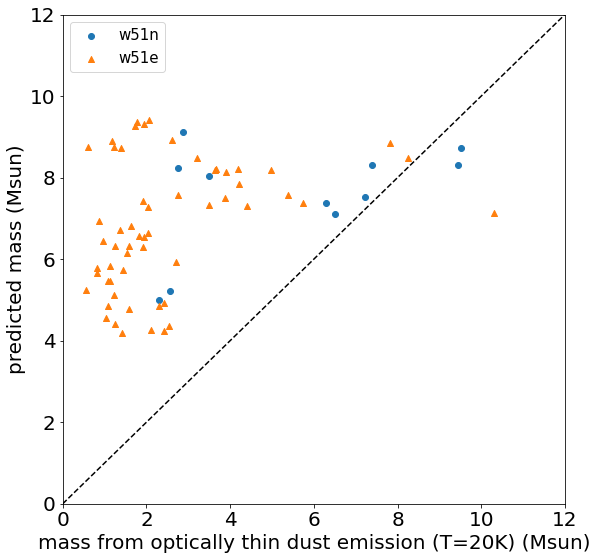

In [102]:

w51e_flux = np.vstack((np.log10(w51e_b3_flux_selected), np.log10(w51e_b6_flux_selected/w51e_b3_flux_selected))).T
w51n_flux = np.vstack((np.log10(w51n_b3_flux_selected), np.log10(w51n_b6_flux_selected/w51n_b3_flux_selected))).T

w51n_mass = 300 * w51n_b6_flux_selected * (5.1/3.9)**2
w51e_mass = 300 * w51e_b6_flux_selected * (5.1/3.9)**2

w51n_mass_predict = 10**model2.predict(w51n_flux)
w51e_mass_predict = 10**model2.predict(w51e_flux)
print(w51e_b6_flux_selected, w51e_mass)

fig = plt.figure(figsize=(9,9))
plt.scatter(w51n_mass, w51n_mass_predict, marker='o', label='w51n')
plt.scatter(w51e_mass, w51e_mass_predict, marker='^', label='w51e')
plt.ylabel('predicted mass (Msun)')
plt.xlabel('mass from optically thin dust emission (T=20K) (Msun)')
plt.xlim(0,12)
plt.ylim(0,12)
plt.plot([0,12],[0,12],ls='dashed',c='k')
plt.legend(fontsize=15)
plt.savefig('mass_comp_obs.png')